# Explore datasets

Some sources :
- Description of type of routes in Paris (bikes = 7%) https://www.insee.fr/fr/statistiques/5012380#graphique-figure2


In [1]:
%load_ext autoreload
%autoreload 2

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from IPython.display import display, Markdown

## Velib data

In [3]:
velib_depart = pd.read_excel("../data_velib/2021_S1_Stations_departs_Paris.xlsx")
velib_arrival = pd.read_excel("../data_velib/2021_S1_Stations_arrivees_Paris.xlsx")
velib_info = pd.read_csv("../data_velib/velib-emplacement-des-stations.csv", sep=";")

Preprocess arrivals and departures

In [4]:
def preprocess_velib_data(df, type="departure"):
    df.columns = ["ID_station", "station_name"] + list(velib_depart.columns)[2:]
    df = df.iloc[1:-2]
    df_processed = df.melt(["ID_station", "station_name"], value_vars=df.columns[2:])
    df_processed.columns = ['ID_station', 'station_name', 'month', 'value']
    df_processed["type"] = type
    
    return df_processed

In [5]:
depart_df = preprocess_velib_data(velib_depart, type="departure")
arrival_df = preprocess_velib_data(velib_arrival, type="arrival")

In [6]:
velib_df = pd.concat([depart_df, arrival_df]).reset_index(drop=True)

In [7]:
velib_df.to_csv("../data_velib/arrivals_departure_velib_2021.csv", sep=";", index=False)

Preprocess velib information

In [8]:
velib_info.columns = ["ID_station", "station_name", "capacity", "coord"]

In [9]:
velib_info[["lat", "long"]] = velib_info["coord"].str.split(",", expand=True)

In [10]:
velib_info

,ID_station,station_name,capacity,coord,lat,long
0,11025,Froment - Bréguet,43,"48.8570414504784,2.37289470306807",48.8570414504784,2.37289470306807
1,6029,Vaugirard - Monsieur le Prince,26,"48.848951441614176,2.3411329463124275",48.848951441614176,2.3411329463124275
2,7025,Octave Gréard - Tour Eiffel,33,"48.856502977695634,2.293178754328878",48.856502977695634,2.293178754328878
3,9028,Moncey - Blanche,17,"48.88006587474148,2.3310810327529907",48.88006587474148,2.3310810327529907
4,10042,Enghien - Faubourg Poissonnière,16,"48.87242006305313,2.348395236282807",48.87242006305313,2.348395236282807
...,...,...,...,...,...,...
1434,22404,Pierre Brossolette - 12 Février 1934,25,"48.8176962416867,2.3076123744249344",48.8176962416867,2.3076123744249344
1435,15044,Dantzig - Lefebvre,33,"48.83013921586756,2.295934036374092",48.83013921586756,2.295934036374092
1436,22007,Commandant Charcot - Bretteville,36,"48.87530570765423,2.2558460757136345",48.87530570765423,2.2558460757136345
1437,8039,Colisée - Champs-Elysées,24,"48.87047539938743,2.3076190799474716",48.87047539938743,2.3076190799474716


**Correlation arrivals departure**

In [51]:
arr_dep_df = arrival_df.drop(columns=["type"]).merge(
    depart_df.drop(columns=["type"]),
    on=["ID_station", "station_name", "month"], 
    how="outer", 
    suffixes=("_dep", "_arr")
)

df["lat"] = df["lat"].astype(float)
df["long"] = df["long"].astype(float)

arr_dep_df = arr_dep_df.merge(velib_info, on=["ID_station", "station_name"], how="left").dropna()
arr_dep_df["value_dep_by_cap"] = arr_dep_df["value_dep"].fillna(0) / arr_dep_df["capacity"].fillna(1)
arr_dep_df["value_arr_by_cap"] = arr_dep_df["value_arr"].fillna(0) / arr_dep_df["capacity"].fillna(1)

In [52]:
arr_dep_df.head()

,ID_station,station_name,month,value_dep,value_arr,capacity,coord,lat,long,value_dep_by_cap,value_arr_by_cap
1,10001,René Boulanger - Lancry,Janvier,4059,4059,62.0,"48.8685433,2.3600032",48.8685433,2.3600032,65.467742,65.467742
2,10003,Hauteville - Bonne Nouvelle,Janvier,2563,2513,17.0,"48.87077436024043,2.349649636832728",48.87077436024043,2.349649636832728,150.764706,147.823529
3,10004,Metz - Faubourg Saint-Denis,Janvier,5205,5172,48.0,"48.870893,2.353521",48.870893,2.353521,108.437500,107.750000
4,10005,Petites Ecuries - Faubourg Poissonnière,Janvier,2987,2949,18.0,"48.87397217237368,2.348388757504776",48.87397217237368,2.348388757504776,165.944444,163.833333
5,10006,Petites Ecuries - Faubourg Saint-Denis,Janvier,6301,6317,28.0,"48.87287120589831,2.3542150855064397",48.87287120589831,2.3542150855064397,225.035714,225.607143


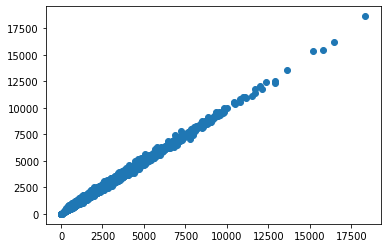

In [162]:
_, ax = plt.subplots()

ax.scatter(corr_df["value_dep"], corr_df["value_arr"])

plt.show()

In [53]:
corr_df = arr_dep_df.dropna()
stats.spearmanr(corr_df["value_dep"], corr_df["value_arr"])

SpearmanrResult(correlation=0.9969159476742987, pvalue=0.0)

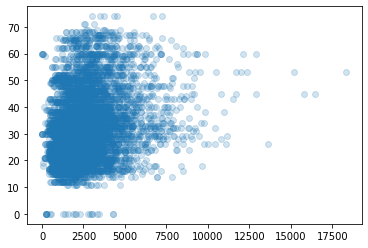

In [164]:
_, ax = plt.subplots()

ax.scatter(corr_df["value_dep"], corr_df["capacity"], alpha=0.2)

plt.show()

In [128]:
corr_df = arr_dep_df.dropna()
stats.spearmanr(corr_df["value_dep"], corr_df["capacity"])

SpearmanrResult(correlation=0.27063451583172254, pvalue=9.521160824529857e-116)

In [129]:
corr_df = arr_dep_df.dropna()
stats.spearmanr(corr_df["value_arr"], corr_df["capacity"])

SpearmanrResult(correlation=0.277211982909759, pvalue=1.4172772879826073e-121)

There is a strong correlation between departure and arrivals in the stations

In [55]:
arr_dep_df_no_na = arr_dep_df.dropna()

In [77]:
df = arr_dep_df_no_na.copy()

In [78]:
df["lat"] = df["lat"].astype(float)
df["long"] = df["long"].astype(float)

In [79]:
df["value_arr"] = df["value_arr"].astype(int)
df["value_dep"] = df["value_dep"].astype(int)

0

In [34]:
def min_max_scale(x):
    return (x - min(x)) / (max(x) - min(x))

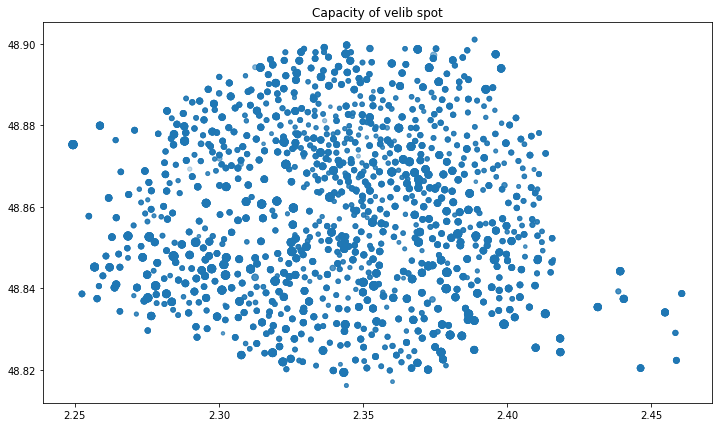

In [161]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(df["long"], df["lat"], s=df["capacity"], alpha=min_max_scale(df["capacity"]))
ax.set_title("Capacity of velib spot")

plt.show()
plt.close()

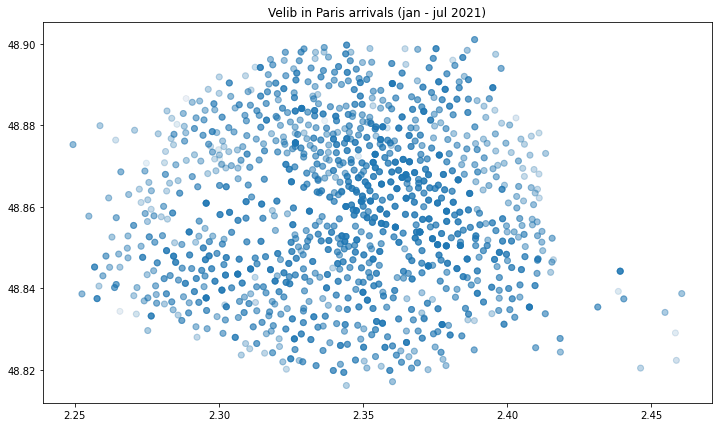

In [159]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(df["long"], df["lat"], alpha=min_max_scale(df["value_arr"]))
ax.set_title("Velib in Paris arrivals (jan - jul 2021)")

plt.show()
plt.close()

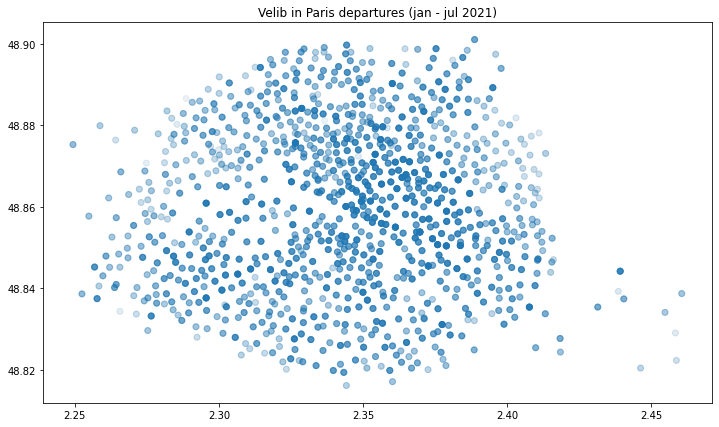

In [160]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(df["long"], df["lat"], alpha=min_max_scale(df["value_dep"]))
ax.set_title("Velib in Paris departures (jan - jul 2021)")

plt.show()
plt.close()

In [80]:
df["month"] = df["month"].replace({
    "Janvier": "01-janvier",
    "Février": "02-fevrier",
    "Mars": "03-mars",
    "Avril": "04-avril",
    "Mai": "05-mai",
    "Juin": "06-juin",
    "Juillet": "07-juillet",
})

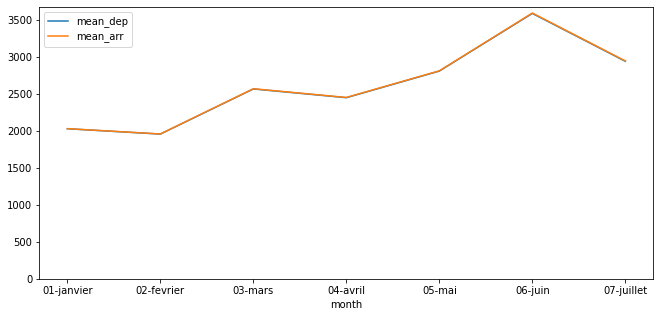

In [81]:
fig, ax = plt.subplots(figsize=(11, 5))
df.groupby("month").agg(
    mean_dep=("value_dep", "mean"),
    mean_arr=("value_arr", "mean"),
).plot(ax=ax)

ax.set_ylim(0)

plt.show()

## Stationnement vélo

https://www.data.gouv.fr/fr/datasets/stationnement-velo-en-ile-de-france/

In [86]:
bike_station = pd.read_csv("../external_data/stationnement-velo-en-ile-de-france.csv", sep=";")
bike_station[["lat", "long"]] = bike_station["geo_point_2d"].str.split(",", expand=True).astype(float)

In [94]:
bike_station_paris = bike_station.loc[bike_station["nom_com"].str.contains("Arron")]
# bike_station_paris

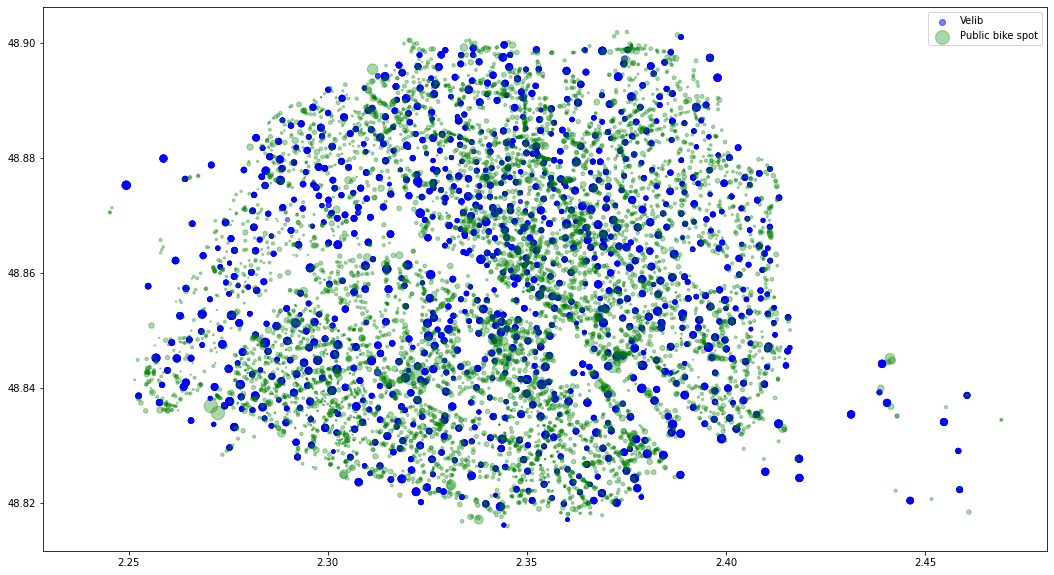

In [144]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.scatter(df["long"], df["lat"], c="blue", alpha=0.5, label="Velib", s=df["capacity"])
ax.scatter(bike_station_paris["long"], bike_station_paris["lat"], c="green", alpha=0.33, label="Public bike spot", s=bike_station_paris["capacite"])

ax.legend()

plt.show()
plt.close()

**10e Arrondissement**

Velib capacity: 13062

Public bike spot capacity: 4581

Total: 17643

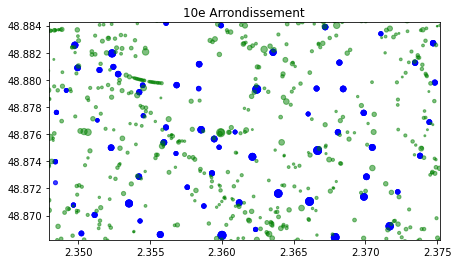

**11e Arrondissement**

Velib capacity: 21294

Public bike spot capacity: 4313

Total: 25607

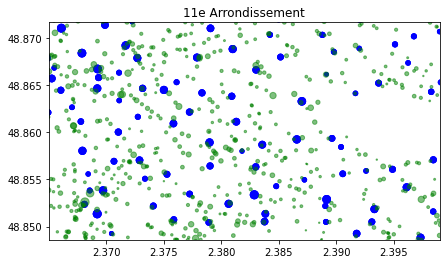

**12e Arrondissement**

Velib capacity: 31529

Public bike spot capacity: 6514

Total: 38043

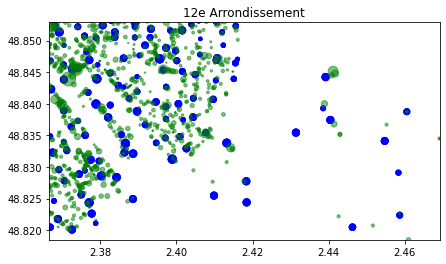

**13e Arrondissement**

Velib capacity: 21804

Public bike spot capacity: 8530

Total: 30334

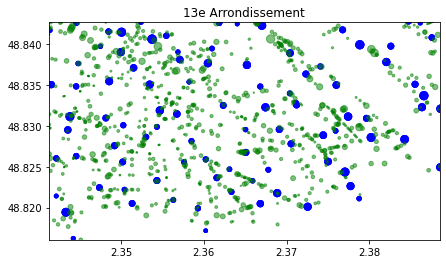

**14e Arrondissement**

Velib capacity: 18706

Public bike spot capacity: 5882

Total: 24588

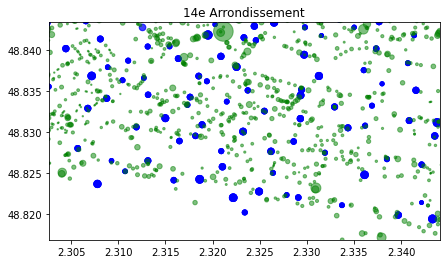

**15e Arrondissement**

Velib capacity: 30306

Public bike spot capacity: 9934

Total: 40240

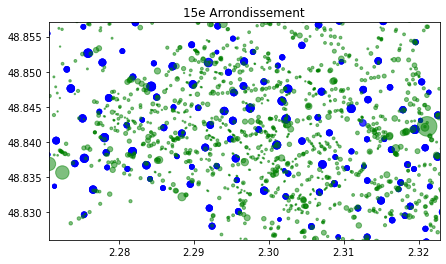

**16e Arrondissement**

Velib capacity: 27967

Public bike spot capacity: 3347

Total: 31314

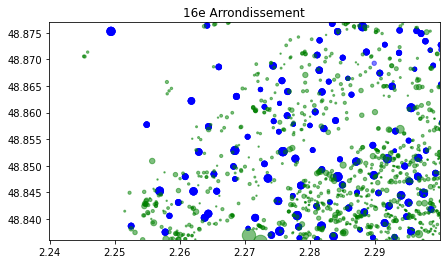

**17e Arrondissement**

Velib capacity: 18904

Public bike spot capacity: 5074

Total: 23978

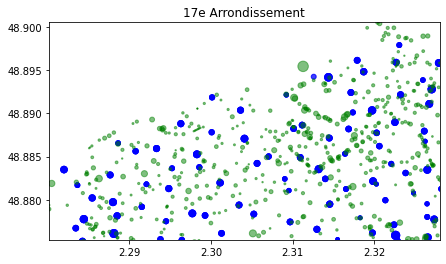

**18e Arrondissement**

Velib capacity: 16518

Public bike spot capacity: 4709

Total: 21227

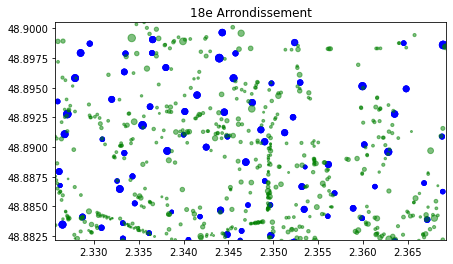

**19e Arrondissement**

Velib capacity: 16209

Public bike spot capacity: 5498

Total: 21707

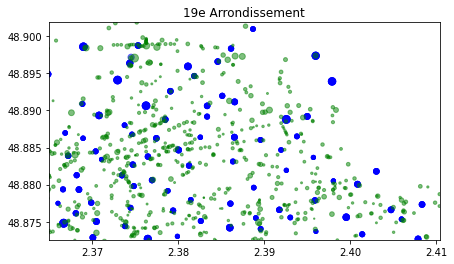

**1er Arrondissement**

Velib capacity: 9548

Public bike spot capacity: 1818

Total: 11366

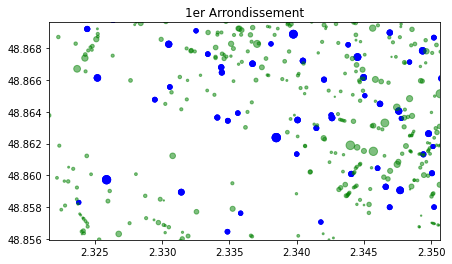

**20e Arrondissement**

Velib capacity: 22725

Public bike spot capacity: 3926

Total: 26651

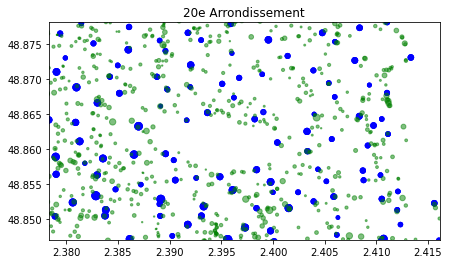

**2e Arrondissement**

Velib capacity: 7420

Public bike spot capacity: 2275

Total: 9695

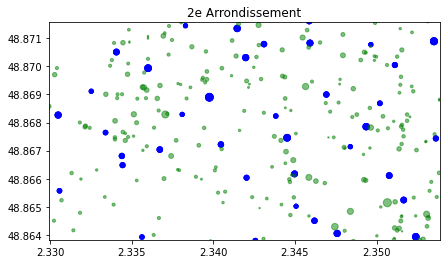

**3e Arrondissement**

Velib capacity: 5362

Public bike spot capacity: 2214

Total: 7576

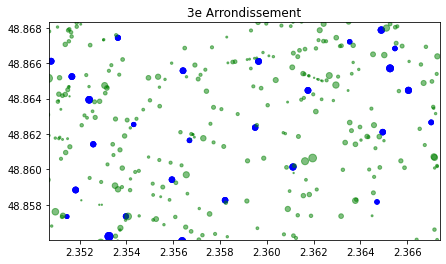

**4e Arrondissement**

Velib capacity: 8092

Public bike spot capacity: 3166

Total: 11258

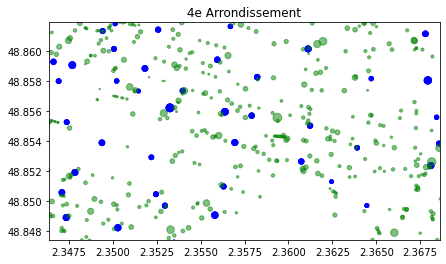

**5e Arrondissement**

Velib capacity: 10384

Public bike spot capacity: 4631

Total: 15015

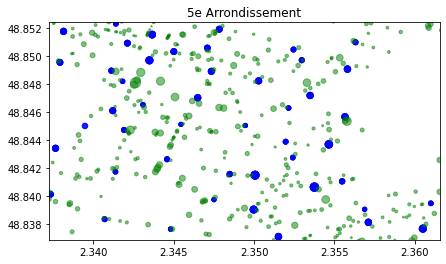

**6e Arrondissement**

Velib capacity: 11700

Public bike spot capacity: 2584

Total: 14284

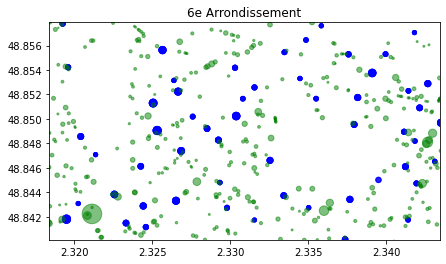

**7e Arrondissement**

Velib capacity: 12759

Public bike spot capacity: 3618

Total: 16377

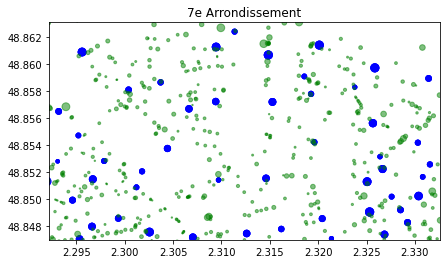

**8e Arrondissement**

Velib capacity: 10538

Public bike spot capacity: 1846

Total: 12384

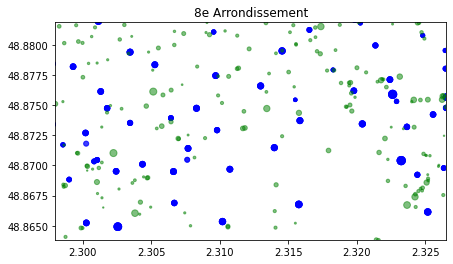

**9e Arrondissement**

Velib capacity: 11289

Public bike spot capacity: 2757

Total: 14046

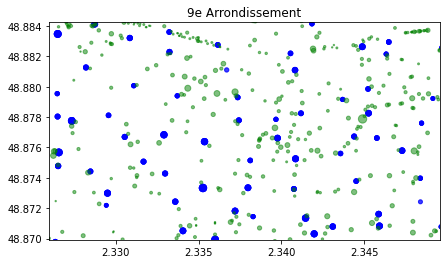

In [147]:
# fig, axes = plt.subplots(5, 4, figsize=(20, 25))

for i, (com, group_df) in enumerate(bike_station_paris.groupby("nom_com")):
    display(Markdown(f"**{com}**"))
    # n_row = int(i / 4)
    # n_col = i % 4
    
    fig, ax = plt.subplots(figsize=(7, 4))
    
    lat_min, lat_max = group_df["lat"].min(), group_df["lat"].max()
    long_min, long_max = group_df["long"].min(), group_df["long"].max()
    
    # ax = axes[n_row, n_col]
    
    df_ = df.loc[(df["lat"] >= lat_min) & (df["lat"] <= lat_max) & (df["long"] >= long_min) & (df["long"] <= long_max)]
    
    cap_velib = int(df_["capacity"].sum())
    cap_bike = group_df["capacite"].sum()
    
    display(Markdown(f"Velib capacity: {cap_velib}"))
    display(Markdown(f"Public bike spot capacity: {cap_bike}"))
    display(Markdown(f"Total: {cap_bike + cap_velib}"))
    
    ax.scatter(df["long"], df["lat"], c="blue", alpha=0.5, label="Velib", s=df["capacity"])
    ax.scatter(bike_station_paris["long"], bike_station_paris["lat"], c="green", alpha=0.5, label="Public bike spot", s=bike_station_paris["capacite"])
    
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlim(long_min, long_max)

    ax.set_title(com)
    
    plt.show()
    plt.close()
    print()


Next steps : 
- Find out where parisians work and live with subway usage : https://data.iledefrance-mobilites.fr/explore/dataset/validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-2e-sem/information/ 
- Compare capacity to number of inhabitant per arrondissement / working people
- Find out trends of bike usage in Paris to see what is the best capacity for bikes
- Data about private bike spot ?
- Find area where coverage is small compare to the number of inhabitants / working people

In [154]:
# pd.read_csv("../external_data/arrondissements.csv", sep=";")